In [1]:
import mindspore
mindspore.set_context(device_target='CPU')
# mindspore.set_context(device_target='GPU')
mindspore.set_context(device_target="Ascend")
mindspore.set_context(device_id=0)
mindspore.run_check()

MindSpore version:  2.1.0
The result of multiplication calculation is correct, MindSpore has been installed on platform [Ascend] successfully!


# 5 对未标记数据进行预训练

截至目前，我们已经完成了数据采样和注意力机制的实现，并成功构建了LLM的架构。现在，是时候着手实现训练函数，并对LLM进行预训练了。预训练是构建大语言模型的关键步骤，它使模型能够从大量未标记文本中学习语言的结构和规律。

<img src="./images_llm/fig5.1.svg"  width='600'>

本章涵盖的主题如下图所示，我们将从评估生成文本开始，随后探讨模型训练方法，最后介绍几种常用的解码策略：

<img src="./images_llm/fig5.2.svg" width='600'>

## 5.1 评估生成文本模型

在开始训练之前，我们需要确立评估模型性能的指标和方法。这一节将介绍如何评估生成文本的质量，以及如何计算模型在训练和验证数据上的损失值。

### 5.1.1 使用GPT生成文本

首先，使用如下配置初始化GPT模型。这里我们定义一个基本的GPT模型配置，包括词汇表大小、上下文长度、嵌入维度等参数。

In [2]:
import mindspore
from previous_chapters import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

mindspore.set_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.set_train(False)  # Disable dropout during inference

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
[WARNING] ME(98110:281473781230448,MainProcess):2025-03-13-18:20:50.374.704 [mindspore/nn/layer/basic.py:171] This parameter `dtype` will be deleted or invisible in the future. Please don't use it.


GPTModel<
  (tok_emb): Embedding<vocab_size=50257, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=tok_emb.embedding_table, shape=(50257, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (pos_emb): Embedding<vocab_size=256, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=pos_emb.embedding_table, shape=(256, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (drop_emb): Dropout<p=0.1>
  (trf_blocks): SequentialCell<
    (0): TransformerBlock<
      (att): MultiHeadAttention<
        (W_query): Dense<input_channels=768, output_channels=768>
        (W_key): Dense<input_channels=768, output_channels=768>
        (W_value): Dense<input_channels=768, output_channels=768>
        (out_proj): Dense<input_channels=768, output_channels=768, has_bias=True>
        (dropout): Dropout<p=0.1>
        >
      (ff): FeedForward<
        (layers): SequentialCell<
          (0): Dense<input_channels=768,

这里的上下文长度（context_length）缩减为256个词元，这一修改有效降低了计算负担。完成我们的训练之后，将调整上下文大小，并加载上下文长度为1024的预训练模型权重。

接着，我们使用GPTModel实例，结合第4章中的generate_text_simple函数生成文本，并应用text_to_token_ids和token_ids_to_text这两个函数实现文本与词元之间的转换。下图展示了这一过程的工作流：

<img src="./images_llm/fig5.3.svg" width='700'>

In [3]:
from transformers import GPT2Tokenizer
from mindspore import Tensor

import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.numpy as np

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        # with mindspore.context.grad_off():
        logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        softmax = ops.Softmax(axis=-1)
        probas = softmax(logits)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = ops.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = ops.concat((idx, idx_next), axis=1)  # (batch, n_tokens+1)

    return idx

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = Tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
     # 检查是否有批量维度，如果有则移除
    if len(token_ids.shape) > 1 and token_ids.shape[0] == 1:
        flat = token_ids.squeeze(0)
    else:
        flat = token_ids
    # flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat)


In [4]:
start_context = "Every effort moves you"
# 指定本地词汇表文件所在的目录路径
local_path = "./gpt2-tokenizer"

# 从本地路径加载GPT - 2分词器
tokenizer = GPT2Tokenizer.from_pretrained(local_path)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Output text:
 Every effort moves you rhythm rhythmaruisleisleisle childish childish childish childish


显然，未经训练的模型无法生成连贯的文本。为了明确什么是"连贯"或"高质量"的文本，我们需要采用一种数值评估方法，使我们能够在整个训练过程中持续监控并提升模型的性能。接下来，我们将为生成的输出计算一个损失指标，这一指标将作为训练的衡量标准。此外，在后续的章节中，当我们对LLM进行微调时，还将介绍评估模型质量的其他方法。

### 5.1.2 计算文本生成损失

为了量化模型生成文本的质量，我们需要定义一个损失函数。在语言模型中，常用的损失函数是交叉熵损失，它衡量模型预测的概率分布与真实分布之间的差异。

假设有2个训练示例，对应的目标张量为输入张量向右移动1个位置的结果。这反映了语言模型的核心任务：预测序列中的下一个词元。

In [5]:
inputs = Tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = Tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

现在，我们把数据输入到模型中，以计算出2个输入张量的logits向量。接着应用softmax函数将logits转换为概率向量，表示模型对每个可能的下一个词元的预测概率。

In [6]:
import mindspore.nn as nn
logits = model(inputs)

softmax = nn.Softmax(axis=-1)
probas = softmax(logits) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

(2, 3, 50257)


下图展示了一个LLM生成文本的总体流程，概述了如何将概率分数转换回文本。模型计算出词汇表中每个词元的概率分布，然后通过某种选择策略（如取最大概率值）来确定下一个词元。

<img src="./images_llm/fig5.4.svg" width='700'>

将argmax函数应用于概率向量后，可以得到两组输出，每组包含3个预测的词元ID：

In [7]:
token_ids = ops.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 [[[40978]
  [32136]
  [40189]]

 [[33768]
  [ 2301]
  [22235]]]


对这些token ID进行解码，可以发现输出的token与期望模型生成的目标token存在显著差异。这表明未训练的模型还没有学会预测合理的下一个词元。

In [8]:
res = token_ids_to_text(targets[0], tokenizer)
print(f"Targets batch 1: {res}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: reth Moody inscription


为了完成模型的训练，我们需要知道预测文本与目标文本之间的距离。交叉熵损失提供了这一度量，它衡量预测概率分布与目标分布之间的差异。

<img src="./images_llm/fig5.5.svg" width='700'>

3个目标词元ID对应的预测概率为：

In [9]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: [1.3572932e-05 1.2135792e-05 1.2359466e-05]
Text 2: [1.1107936e-05 3.2941804e-05 3.0851545e-05]


训练LLM的目标是最大化正确词元的预测概率（接近1）。通过计算对数概率，我们可以更方便地处理极小的概率值：

In [10]:
# Compute logarithm of all token probabilities
log_probas = ops.log(ops.concat((target_probas_1, target_probas_2)))
print(log_probas)

[-11.207433 -11.319351 -11.301088 -11.40785  -10.320768 -10.386324]


计算平均对数概率：

In [11]:
# Calculate the average probability for each token
avg_log_probas = np.mean(log_probas)
print(avg_log_probas)

-10.99047


模型训练的目标是通过更新模型的权重，使得平均对数概率尽可能接近0（即预测概率接近1）。然而，在深度学习的实际应用中，我们通常会将对数损失函数乘以-1（即使用负对数概率），然后最小化这个值。这样处理可以使训练过程更加稳定，并与其他深度学习模型的损失函数保持一致。

In [12]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

10.99047


MindSpore中有一个内置的cross_entropy函数，能够一步完成上述六个步骤，极大地简化了损失计算的流程：

<img src="./images_llm/fig5.6.svg" width='600'>

In [13]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: (2, 3, 50257)
Targets shape: (2, 3)


In [14]:
logits_flat = ops.flatten(logits, start_dim=0, end_dim=1)
targets_flat = ops.flatten(targets, start_dim=0, end_dim=1)

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: (6, 50257)
Flattened targets: (6,)


In [15]:
loss = ops.cross_entropy(logits_flat, targets_flat)
print(loss)

10.99047


与交叉熵损失相关的一个重要概念是困惑度（perplexity）。困惑度是交叉熵损失的指数，它提供了另一种评估语言模型的方式。困惑度可以解释为模型在每个位置平均需要考虑的词汇数量。较低的困惑度表示模型更有信心预测正确的下一个词元，因此生成更流畅、更自然的文本。

In [16]:
perplexity = np.exp(loss)
print(perplexity)

59306.25


### 5.1.3 计算训练和验证集损失

为了评估模型的泛化能力，我们需要在训练集和验证集上计算损失。这里使用了一个简短的文本数据集——the-verdict.txt：

In [17]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/Miao109/llm_mindspore/refs/heads/main/the-verdict.txt?token=GHSAT0AAAAAADAOHYA7TYWCH2P3VLK7CS2KZ6SVODA"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

快速查看这一数据集：

In [18]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [19]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [20]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (5145 > 1024). Running this sequence through the model will result in indexing errors


Characters: 20479
Tokens: 5145


可以看到，这个数据集仅包含5,145个词元，相对较小。接下来，我们将把这个数据集划分为训练集和验证集，并利用第2章中的数据加载器为LLM训练准备数据。这里我们采用上下文窗口为GPT_CONFIG_124M["context_length"]的滑动窗口方法，每个样本包含连续的词元序列。

<img src="./images_llm/fig5.7.svg" width='800'>

考虑到我们处理的数据集规模较小，为了降低计算资源的需求，这里选择了相对较小的批处理大小（batch_size=2）。在实际大规模训练中，通常会使用更大的批处理大小以提高训练效率。

In [21]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


mindspore.set_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.
Token indices sequence length is longer than the specified maximum sequence length for this model (4612 > 1024). Running this sequence through the model will result in indexing errors
Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


In [22]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [23]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)
(2, 256) (2, 256)

Validation loader:
(2, 256) (2, 256)


In [24]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


接下来，我们实现一个辅助函数，用于计算特定批次数据上的交叉熵损失。calc_loss_batch函数计算单个批次的损失，而calc_loss_loader函数则计算整个数据加载器的平均损失，便于我们监控模型在训练和验证集上的性能。

In [25]:
def calc_loss_batch(input_batch, target_batch, model):
    logits = model(input_batch)
    loss = ops.cross_entropy(ops.flatten(logits, start_dim=0, end_dim=1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

现在我们可以使用这些函数来计算模型在训练和验证集上的初始损失值，这将作为训练过程中的基准参考点：

In [26]:
mindspore.set_seed(123) # For reproducibility due to the shuffling in the data loader

# with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
train_loss = calc_loss_loader(train_loader, model)
val_loss = calc_loss_loader(val_loader, model)

print("Training loss:", train_loss, type(train_loss))
print(f"Train loss {train_loss.asnumpy():.3f}, Val loss {val_loss.asnumpy():.3f}")
print("Validation loss:", val_loss)

Training loss: 10.996593 <class 'mindspore.common._stub_tensor.StubTensor'>
Train loss 10.997, Val loss 10.983
Validation loss: 10.983248


## 5.2 训练 LLM

完成了评估准备工作后，我们现在可以实现预训练LLM的代码了。预训练过程涉及将模型暴露于大量未标记文本数据，使其学习预测序列中的下一个词元。

<img src="./images_llm/fig5.8.svg" width='600'>

为了保持代码的简洁易读，我们将构建一个简单的训练循环。该循环包括前向传播计算损失、反向传播计算梯度、以及使用优化器更新模型参数三个关键步骤。

<img src="./images_llm/fig5.9.svg" width='500'>

In [27]:
from mindspore import value_and_grad
def train_model_simple(model, train_loader, val_loader, optimizer, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    # 定义前向传播函数
    def forward_fn(input_batch, target_batch):
        loss = calc_loss_batch(input_batch, target_batch, model)
        return loss
    
    # 获取计算梯度的函数
    grad_fn = value_and_grad(forward_fn, None, optimizer.parameters)

    # Main training loop
    for epoch in range(num_epochs):
        model.set_train(True)  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            # loss = calc_loss_batch(input_batch, target_batch, model)
            # 计算损失和梯度
            loss, grads = grad_fn(input_batch, target_batch)
            
            # 使用优化器更新参数
            grads = ops.clip_by_global_norm(grads, clip_norm=0.5)  # 严格裁剪
            optimizer(grads)

            # loss.backward() # Calculate loss gradients
            # optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss.asnumpy():.3f}, Val loss {val_loss.asnumpy():.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, eval_iter):
    model.set_train(False)
    train_loss = calc_loss_loader(train_loader, model, num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader, model, num_batches=eval_iter)
    model.set_train(True)
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, start_context):
    model.set_train(False)
    context_size = model.pos_emb.embedding_table.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer)
    token_ids = generate_text_simple(
        model=model, idx=encoded,
        max_new_tokens=50, context_size=context_size
    )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.set_train(True)

现在，我们使用AdamW优化器，并结合之前定义的train_model_simple函数，对LLM进行训练。AdamW是Adam优化器的一个变体，增加了权重衰减正则化，有助于减少过拟合。我们指定训练10个epoch，每5步评估一次模型性能。

In [28]:
mindspore.set_seed(1)
model = GPTModel(GPT_CONFIG_124M)

optimizer = nn.AdamWeightDecay(model.trainable_params(), learning_rate=1e-4, weight_decay=1e-4)

num_epochs = 20
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

[WARNING] ME(98110:281473781230448,MainProcess):2025-03-13-18:23:15.490.66 [mindspore/nn/layer/basic.py:171] This parameter `dtype` will be deleted or invisible in the future. Please don't use it.


Ep 1 (Step 000000): Train loss 10.077, Val loss 10.243
Ep 1 (Step 000005): Train loss 8.581, Val loss 8.789


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you..................................................
Ep 2 (Step 000010): Train loss 7.235, Val loss 7.482
Ep 2 (Step 000015): Train loss 6.475, Val loss 6.804


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 3 (Step 000020): Train loss 6.250, Val loss 6.608
Ep 3 (Step 000025): Train loss 6.112, Val loss 6.644


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 4 (Step 000030): Train loss 6.066, Val loss 6.656


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Ep 4 (Step 000035): Train loss 6.046, Val loss 6.671
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 5 (Step 000040): Train loss 5.999, Val loss 6.702


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 6 (Step 000045): Train loss 6.009, Val loss 6.721
Ep 6 (Step 000050): Train loss 5.969, Val loss 6.716


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 7 (Step 000055): Train loss 6.003, Val loss 6.703
Ep 7 (Step 000060): Train loss 5.901, Val loss 6.689


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 8 (Step 000065): Train loss 5.868, Val loss 6.669
Ep 8 (Step 000070): Train loss 5.819, Val loss 6.645


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 9 (Step 000075): Train loss 5.799, Val loss 6.645


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Ep 9 (Step 000080): Train loss 5.775, Val loss 6.622
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 10 (Step 000085): Train loss 5.720, Val loss 6.612


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 11 (Step 000090): Train loss 5.745, Val loss 6.635
Ep 11 (Step 000095): Train loss 5.669, Val loss 6.609


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you, the the the the the the the the the the the, the the the the the,, the the the the, the the the the the, the,, the the,,,, the the,,, the the the the the
Ep 12 (Step 000100): Train loss 5.641, Val loss 6.604
Ep 12 (Step 000105): Train loss 5.549, Val loss 6.599


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the, the the the the the the the the the the the, the the the the the the the
Ep 13 (Step 000110): Train loss 5.470, Val loss 6.701
Ep 13 (Step 000115): Train loss 5.399, Val loss 6.664


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you the the the a a a a a, the the the the the the the the the the the the a the the the the the the the the the the the the the the the the the the, the, the the the the the the the
Ep 14 (Step 000120): Train loss 5.261, Val loss 6.698


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Ep 14 (Step 000125): Train loss 5.260, Val loss 6.773
Every effort moves you the the a a of the a a a--.                                       
Ep 15 (Step 000130): Train loss 5.154, Val loss 6.727


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you that that that the the the the the the I had-- it had-- had-- it, I was.                            
Ep 16 (Step 000135): Train loss 5.172, Val loss 6.747
Ep 16 (Step 000140): Train loss 5.031, Val loss 6.783


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you I I I, I, I, the I, the the the the the the I, I, the the I, the I, the the I, I, I, I, the I, the to the I, the I, I
Ep 17 (Step 000145): Train loss 5.059, Val loss 6.620
Ep 17 (Step 000150): Train loss 4.958, Val loss 6.816


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the, on the the the the the to the the the the the the the the on the the the the on the the the the the
Ep 18 (Step 000155): Train loss 4.859, Val loss 6.784
Ep 18 (Step 000160): Train loss 4.704, Val loss 6.792


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you a a a a-- a a to to a a a a to a to a------------ "-- on a one, the a a a a a one-- on the one of the a a one of the a one of
Ep 19 (Step 000165): Train loss 4.605, Val loss 6.773


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Ep 19 (Step 000170): Train loss 4.504, Val loss 6.827
Every effort moves you through a a to to a to to to to a to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to--. I had on to
Ep 20 (Step 000175): Train loss 4.370, Val loss 6.850


Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Every effort moves you through a a a-- a to a-- it. I had to to on to it. I was-- it was was-- it had to to it. I was was was was was was was-- it was was was was-- was was--


将训练和验证集的损失变化可视化，以便更直观地对比和分析模型的学习过程：

In [29]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


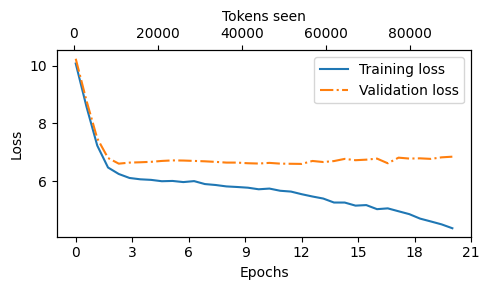

In [30]:


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = ops.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

从训练结果可以观察到以下几点：

- 模型在训练初期生成的文本通常是难以理解的随机字符串，而随着训练进行，它逐渐能够生成语法或多或少正确的句子，表明模型正在学习语言的基本结构。

- 然而，通过比较训练集和验证集的损失曲线，可以发现模型开始出现过拟合现象，即模型在训练集上的性能持续改善，但在验证集上的性能开始停滞或恶化。

- 如果仔细检查模型在训练后期生成的一些段落，会发现它们几乎一字不差地出现在训练集中——这表明模型开始简单地记住训练数据，而不是学习泛化能力。

- 在后续章节中，我们将介绍一些解码策略，这些策略能在一定程度上减轻这种记忆现象，增加生成文本的多样性。

- 需要注意的是，这里的过拟合主要是因为我们的训练集非常小，而且我们对其进行了多次迭代。在实际的大规模LLM训练中，使用足够大的数据集和适当的正则化技术可以有效减轻过拟合问题。

- 本章的LLM训练主要出于教育目的，让我们能够直观地理解模型学习过程；在实际应用中，通常需要更大的数据集和更复杂的训练策略。

## 5.3 解码策略

生成模型的解码策略是指从模型输出的概率分布中选择下一个词元的方法。不同的解码策略会导致生成文本具有不同的特性，如创造性、多样性和连贯性。下面，我们首先检查未训练模型的输出：

In [31]:
model.set_train(False)
# 指定本地词汇表文件所在的目录路径
local_path = "./gpt2-tokenizer"
# 从本地路径加载GPT - 2分词器
tokenizer = GPT2Tokenizer.from_pretrained(local_path)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Output text:
 Every effort moves you through a a a-- a to a-- it. I had to to on to it. I was-- it was was


可以看到，未训练的模型输出仍然是无意义的词元序列。接下来，我们将探索几种常用的解码策略，以改善生成文本的质量。

## 5.3.1 Temperature scaling

Temperature scaling是LLM中用于控制生成文本多样性和随机性的关键技术。它通过调整softmax函数前的logits值来影响最终的概率分布。

在之前的generate_text_simple函数中，我们使用torch.argmax（也称为贪婪解码）将概率最高的词元作为下一个词元。这种方法总是选择最可能的下一个词元，但可能导致生成的文本缺乏多样性，甚至陷入重复模式。

首先，为了生成更多样化的文本，我们可以替换掉argmax，采用一种从概率分布中采样的方法。这允许模型有时选择概率较低的词元，增加生成文本的变化性。

In [49]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = Tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
softmax = nn.Softmax(axis=0)
probas = softmax(next_token_logits)
next_token_id = ops.argmax(probas)
next_token_id = int(next_token_id.asnumpy())
# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [33]:
mindspore.set_seed(123)
next_token_id = ops.multinomial(probas, num_samples=1)
next_token_id = int(next_token_id.asnumpy())
print(inverse_vocab[next_token_id])

forward


使用多项式分布采样允许模型根据预测的概率分布随机选择下一个词元，这比贪婪解码能生成更多样化的文本。

为便于说明，我们根据预测的概率进行1000次采样，观察不同词元被选中的频率：

In [34]:
def print_sampled_tokens(probas):
    mindspore.set_seed(123) # Manual seed for reproducibility
    sample = [int(ops.multinomial(probas, num_samples=1).asnumpy()) for i in range(1_000)]
    sampled_ids = ops.bincount(Tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

65.0 x closer
1.0 x every
0.0 x effort
563.0 x forward
4.0 x inches
0.0 x moves
0.0 x pizza
364.0 x toward
3.0 x you


其次，为了进一步控制这一选择过程，我们引入temperature缩放这一概念。Temperature是一个正值参数，用于调整logits分布的"尖锐度"：

当temperature=1时，概率分布保持不变

当temperature<1时，概率分布变得更尖锐，高概率词元被选中的可能性增加，生成的文本更加确定性和一致性

当temperature>1时，概率分布变得更平坦，不同词元被选中的可能性更加均衡，生成的文本更加多样和创造性

In [35]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    softmax = nn.Softmax(axis=0)
    return softmax(scaled_logits)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

下面我们可视化不同temperature值对概率分布的影响：

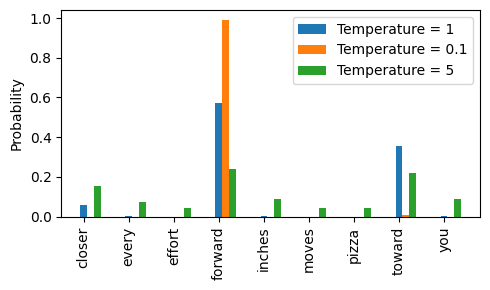

In [36]:
import numpy
# Plotting
x = numpy.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    scaled_prob = scaled_probas[i].asnumpy()
    rects = ax.bar(x + i * bar_width, scaled_prob, bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

我们可以观察到，降低temperature使概率分布更加集中于高概率词元：

In [37]:
print_sampled_tokens(scaled_probas[1])

0.0 x closer
0.0 x every
0.0 x effort
990.0 x forward
0.0 x inches
0.0 x moves
0.0 x pizza
10.0 x toward


而提高temperature则使概率分布更加均匀，增加了低概率词元被选中的可能性：

In [38]:
print_sampled_tokens(scaled_probas[2])

148.0 x closer
80.0 x every
44.0 x effort
256.0 x forward
75.0 x inches
44.0 x moves
38.0 x pizza
222.0 x toward
93.0 x you


当temperature=5时，概率分布变得更加平坦，即使"forward"的原始概率远高于"pizza"，在采样时二者被选中的概率差距也大大减小。这种平衡可以帮助模型生成更加创新和多样化的文本，但太高的temperature可能导致生成的文本缺乏连贯性和意义。

### 5.3.2 Top-k 采样

Top-k采样是另一种常用的解码策略，它通过限制模型在每个生成步骤中仅考虑概率最高的前k个候选词，从而平衡生成结果的多样性与合理性。这种方法避免了模型选择极低概率的词元，这些词元可能导致生成的文本语义不连贯。

<img src="./images_llm/fig5.10.svg" width='600'>

Top-k方法通过将所有未选中的 `logit` 值替换为 `-inf`，使得在计算概率值时，非top-k词元的概率得分为 0，其余词元的概率总和保持为1。

首先，我们找出logits中前k个最大值及其位置：

In [50]:
top_k = 3
top_logits, top_pos = ops.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: [6.75      6.28125   4.5117188]
Top positions: [3 7 0]


然后，将非top-k词元的logits设置为负无穷大，确保它们在softmax后的概率为0：

In [51]:
new_logits = ops.where(
    condition=next_token_logits < top_logits[-1],
    x=Tensor(float("-inf")), 
    y=next_token_logits
)

print(new_logits)

[-inf -inf -inf 6.75 -inf -inf -inf 6.28 -inf]


最后，应用softmax获得仅包含top-k词元的概率分布：

In [52]:
softmax = nn.Softmax(axis=0)
topk_probas = softmax(new_logits)
print(topk_probas)

[0.         0.         0.         0.6153837  0.         0.
 0.         0.38461632 0.        ]


### 5.3.3 修改文本生成函数

现在，我们将温度缩放和top-k采样相结合，对之前用于通过LLM生成文本的`generate_text_simple`函数进行改进，创建一个新的`generate`函数。这个新函数提供了更多的灵活性，允许调整temperature和top-k参数来控制生成文本的特性：

In [53]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx = ops.cast(idx, mindspore.int32)
        idx_cond = idx[:, -context_size:]

        logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = ops.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = ops.where(logits < min_val, Tensor(float("-inf")), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            softmax = nn.Softmax(axis=-1)
            probs = softmax(logits)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = ops.multinomial(probs, num_samples=1, replacement=False)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = ops.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)
        # print(idx_next)
        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = ops.cat((idx, idx_next), axis=1)  # (batch_size, num_tokens+1)

    return idx

使用新的`generate`函数，我们可以结合top-k采样和temperature调整来生成更加多样化和有意义的文本：

In [54]:
mindspore.set_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Output text:
 Every effort moves you sun foris of so more, a put one the put put forburn


生成的文本显示，即使使用未经过充分训练的模型，通过适当的解码策略也能在一定程度上改善输出质量。在实际应用中，选择合适的解码参数对于平衡文本的创造性和连贯性至关重要：

- 较低的temperature（如0.7）和适中的top-k值（如40）适合生成连贯、保守的回应

- 较高的temperature（如1.2）和较大的top-k值（如100）适合生成创造性、多样化的内容

- 在生成诗歌、故事等创意内容时，可以使用较高的temperature

- 在生成技术文档、代码等精确内容时，可以使用较低的temperature

## 5.4 加载和保存模型权重

在实际应用中，保存和加载模型权重是必不可少的功能，它允许我们保存训练进度，并在需要时恢复模型状态。MindSpore提供了简便的API来实现这一功能。

<img src="./images_llm/fig5.11.svg" width='600'>


保存模型的训练参数：

In [55]:
mindspore.save_checkpoint(model, "model_pretrained.ckpt")

加载保存的权重：

In [56]:
model = GPTModel(GPT_CONFIG_124M)
param_dict = mindspore.load_checkpoint("model_pretrained.ckpt")
param_not_load, _ = mindspore.load_param_into_net(model, param_dict)
print(param_not_load) # param_not_load是未被加载的参数列表，为空时代表所有参数均加载成功。
model.set_train(False)

[WARNING] ME(98110:281473781230448,MainProcess):2025-03-13-19:39:28.332.488 [mindspore/nn/layer/basic.py:171] This parameter `dtype` will be deleted or invisible in the future. Please don't use it.


[]


GPTModel<
  (tok_emb): Embedding<vocab_size=50257, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=tok_emb.embedding_table, shape=(50257, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (pos_emb): Embedding<vocab_size=256, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=pos_emb.embedding_table, shape=(256, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (drop_emb): Dropout<p=0.1>
  (trf_blocks): SequentialCell<
    (0): TransformerBlock<
      (att): MultiHeadAttention<
        (W_query): Dense<input_channels=768, output_channels=768>
        (W_key): Dense<input_channels=768, output_channels=768>
        (W_value): Dense<input_channels=768, output_channels=768>
        (out_proj): Dense<input_channels=768, output_channels=768, has_bias=True>
        (dropout): Dropout<p=0.1>
        >
      (ff): FeedForward<
        (layers): SequentialCell<
          (0): Dense<input_channels=768,

模型权重的保存和加载不仅对于恢复中断的训练过程很重要，也是部署模型和分享预训练模型的基础。通过保存检查点，我们可以：

1. 在训练过程中定期保存模型，防止因意外中断导致的训练进度丢失
2. 选择表现最佳的模型版本进行部署
3. 在不同的计算环境之间迁移模型
4. 与其他研究者分享预训练模型，便于进一步的研究和应用

## 5.5 从 OpenAI 加载预训练权重

除了从头训练模型外，我们还可以利用已有的预训练模型权重。OpenAI发布了多个版本的GPT-2预训练权重，我们可以将这些权重加载到我们的模型架构中。

首先，我们需要安装必要的依赖：

In [ ]:
! pip install  tqdm

从 gpt_download.py 文件中导入 download_and_load_gpt2 函数，如下所示。该函数将 GPT-2 架构设置 (settings) 和权重参数 (params) 加载到Python会话中：

In [58]:
# Relative import from the gpt_download.py contained in this folder
from gpt_download import download_and_load_gpt2

下面我们下载并加载GPT-2模型：

In [60]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

查看加载的模型设置：

In [61]:
print("Settings:", settings)

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


查看参数字典的结构：

In [62]:
print("Parameter dictionary keys:", params.keys())

Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


params字典存储LLM架构和权重信息。我们可以查看其中的一部分，例如词元嵌入权重：

In [63]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


我们通过 `download_and_load_gpt2(model_size="124M", ...)` 下载并加载了最小 GPT-2 模型的权重。OpenAI还提供了几种不同大小的预训练模型，每种模型具有不同的参数规模和能力：

<img src="./images_llm/fig5.12.svg" width='600'>

首先，我们创建一个字典，列出图中不同 GPT 模型大小之间的差异：

In [65]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}


这些不同大小的模型在参数数量、嵌入维度、层数和注意力头数上有所不同。通常，参数量越大的模型表现越好，但计算需求也越高。

假设加载最小的模型“`gpt2-small (124M)`”，可以使用 `model_configs` 表中的相应设置来更新 `GPT_CONFIG_124M`：

In [66]:

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.set_train(False)

[WARNING] ME(98110:281473781230448,MainProcess):2025-03-13-19:40:31.158.797 [mindspore/nn/layer/basic.py:171] This parameter `dtype` will be deleted or invisible in the future. Please don't use it.


GPTModel<
  (tok_emb): Embedding<vocab_size=50257, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=tok_emb.embedding_table, shape=(50257, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (pos_emb): Embedding<vocab_size=1024, embedding_size=768, use_one_hot=False, embedding_table=Parameter (name=pos_emb.embedding_table, shape=(1024, 768), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
  (drop_emb): Dropout<p=0.1>
  (trf_blocks): SequentialCell<
    (0): TransformerBlock<
      (att): MultiHeadAttention<
        (W_query): Dense<input_channels=768, output_channels=768, has_bias=True>
        (W_key): Dense<input_channels=768, output_channels=768, has_bias=True>
        (W_value): Dense<input_channels=768, output_channels=768, has_bias=True>
        (out_proj): Dense<input_channels=768, output_channels=768, has_bias=True>
        (dropout): Dropout<p=0.1>
        >
      (ff): FeedForward<
        (layers): Sequentia

接下来，我们定义一个辅助函数，用于检查和设置参数形状：

In [67]:
def assign(left, right):
    print(f"Shape. Left: {left.shape}, Right: {right.shape}")
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return mindspore.Parameter(Tensor(right))

接下来，我们定义一个 `load_weights_into_gpt` 函数，将 `params` 字典中的权重加载到 `GPTModel` 实例中:

In [68]:
import numpy as np
from mindspore import Tensor

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.embedding_table = assign(gpt.pos_emb.embedding_table, params['wpe'])
    gpt.tok_emb.embedding_table = assign(gpt.tok_emb.embedding_table, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)

Shape. Left: (1024, 768), Right: (1024, 768)
Shape. Left: (50257, 768), Right: (50257, 768)
Shape. Left: (768, 768), Right: (768, 768)
Shape. Left: (768, 768), Right: (768, 768)
Shape. Left: (768, 768), Right: (768, 768)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768, 768), Right: (768, 768)
Shape. Left: (768,), Right: (768,)
Shape. Left: (3072, 768), Right: (3072, 768)
Shape. Left: (3072,), Right: (3072,)
Shape. Left: (768, 3072), Right: (768, 3072)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768, 768), Right: (768, 768)
Shape. Left: (768, 768), Right: (768, 768)
Shape. Left: (768, 768), Right: (768, 768)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768,), Right: (768,)
Shape. Left: (768, 768), Right: (768, 768)
Shape. Left: (768

这个函数将预训练的权重映射到我们的模型架构中，使得我们可以直接使用预训练模型的能力。这是一个重要的技术，因为从头训练一个大型语言模型需要大量的计算资源和数据。

如果模型加载正确，我们可以使用它通过我们之前的 `generate` 函数生成新文本：

In [71]:
mindspore.set_seed(12)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Output text:
 Every effort moves you as far as you can from one point to another, and each step means nothing except your progress.


This post was


可以看到，使用预训练权重的模型生成的文本比从头训练的模型更加连贯和有意义。这是因为预训练模型已经从大量文本数据中学习了语言的结构和模式。

## 5.6 总结

在本章中，我们实现了大语言模型的预训练过程，并探索了几种常用的文本生成解码策略。主要内容包括：

1. 评估生成文本模型：我们学习了如何使用交叉熵损失和困惑度来评估语言模型的性能。
2. 训练LLM：我们实现了一个简单的训练循环，用于在未标记文本数据上预训练语言模型。
3. 解码策略：我们探讨了几种关键的解码策略，包括贪婪解码、温度缩放和top-k采样，它们对于控制生成文本的质量和多样性至关重要。
4. 模型权重管理：我们学习了如何保存和加载模型权重，以及如何使用预训练的GPT-2模型权重。

这些技术为构建和使用大语言模型提供了坚实的基础。在实际应用中，我们可以根据具体需求选择不同规模的预训练模型，并使用适当的解码策略来生成所需类型的文本。

在下一章中，我们将探讨如何对预训练模型进行微调，使其适应特定的任务和领域。